# Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

from scipy.optimize import minimize
from numpy import linalg as LA

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
vf_size = (15,15)
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc

xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))
# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))
# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

### I just realised when reading ex. 2 that I picked the wrong model... Since the process to solve this exercise is the same, I will leave this.

In [9]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1, dt=0.1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S, dt=0.1):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

In [10]:
def main_func(K, stim_duration):
    duration = stim_duration
    dt = .1
    std_dev = 1
    vf_size = (15,15)
    n_bins = round(duration / float(dt))

    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    spike_rate = 5 # average firing rate 
    offset = 2.

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat, dt), method = 'Newton-CG', jac = grad)

    K_est = res.x
    
    return K_est

In [3]:
def Pearson_corr_func(K, K_est):
    cc = np.dot(K.ravel(), K_est[:-1]) / (LA.norm(K)*LA.norm(K_est))
    return cc

In [38]:
durs = [5, 10, 20, 40, 80, 160, 320, 640]
K_est_lst = []
cc_lst = []
for dur in tqdm(durs):
    tmp_cc_lst = []
    for i in range(0,10):
        K_est = main_func(K, dur)
        K_est_lst.append(K_est)
        tmp_cc = Pearson_corr_func(K,K_est)
        tmp_cc_lst.append(tmp_cc)
    cc = np.mean(tmp_cc_lst)
    cc_lst.append(cc)

 12%|█████▋                                       | 1/8 [00:04<00:30,  4.33s/it]/var/folders/39/ynbc235d74zb60hkgml98k6c0000gn/T/ipykernel_10728/121835779.py:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
100%|█████████████████████████████████████████████| 8/8 [02:11<00:00, 16.46s/it]


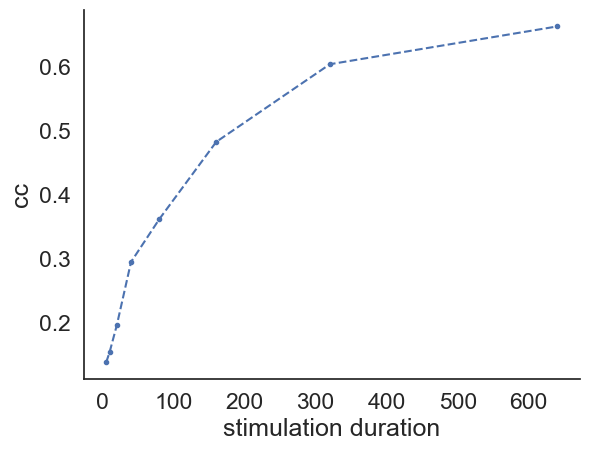

In [40]:
plt.plot(durs, cc_lst, '.--')
plt.xlabel('stimulation duration')
plt.ylabel('cc')
plt.show()

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

### As said above for ex.1 I just the other model there, but I will use the right one here

In [6]:
def main_func_ex2(K, noise = 1):
    noise_variance = noise
    
    duration = 100.
    dt = .1
    std_dev = 1
    vf_size = (15,15)
    n_bins = round(duration / float(dt))

    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

    offset = 2.

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)
    # 2. nonlinear stage (for a linear model: f -> identity function)
    rate = ks
    # add Gaussian noise centered around the "true" rate for each bin
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)
    
    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
    K_hat = K_hat[:-1].reshape(vf_size)
    
    return K_hat

In [10]:
def Pearson_corr_func_ex2(K, K_est):
    cc = np.dot(K.ravel(), K_est.ravel()) / (LA.norm(K)*LA.norm(K_est))
    return cc

In [11]:
noises = [0, 2, 4, 6, 8, 10]
K_est_lst = []
cc_lst = []
for dur in tqdm(noises):
    tmp_cc_lst = []
    for i in range(0,10):
        K_est = main_func_ex2(K, dur)
        K_est_lst.append(K_est)
        tmp_cc = Pearson_corr_func_ex2(K,K_est)
        tmp_cc_lst.append(tmp_cc)
    cc = np.mean(tmp_cc_lst)
    cc_lst.append(cc)

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


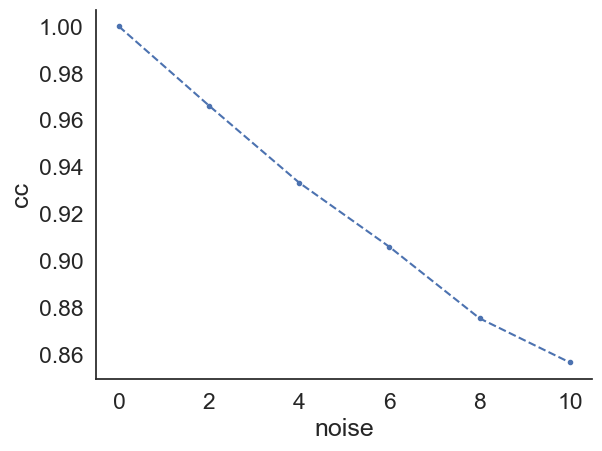

In [12]:
plt.plot(noises, cc_lst, '.--')
plt.xlabel('noise')
plt.ylabel('cc')
plt.show()

## Exercise 3
---
What happens if the neural response is related to the filtered stimulus by a nonlinear function  $r = f_\mathrm{nonlinear}(\mathbf{k}^T \mathbf{s})$, e.g., by setting the `f_nonlin` argument in the data generation function to `f_threshold_quadratic` in excercise 1? Why does the linear estimator still provide a reliable estimate of the true RF? What happens if you use a full quadratic nonlinearity and set the `offset` term to 0? For more details, see Sharpee Ann Rev Neurosci (2013) (link in "Background" section).

## Exercise 4
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




## Exercise 5
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 